# P_bar Notebook

In this notebook, I will change the order of coordinate transformation steps so that individuals are converted from a vertical coordinate of p to one of p_bar(rho). Then, after this has been done for individual temperature and salinity profiles, I will perform the rest of the analysis steps to calculate variance production, eddy diffusivity, and eddy fluxes. At some ppoint I'd also like to do a side-by-side comparison between the results for this order, and the order of moving to p_bar space at the end.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate

In [2]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff
import density_funcs as df

In [3]:
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize']  = 18
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## Load Dataset and Make Section

In [4]:
ds_x = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc')

In [5]:
section = ds_x.where((ds_x.LATITUDE < -25) & (ds_x.LATITUDE > -35),drop=True).where((ds_x.LONGITUDE < -138) & (ds_x.LONGITUDE > -140),drop=True).sortby('LATITUDE')

In [6]:
section = section.sortby('N_PROF')

In [7]:
#only keep profiles with at least n data points
#ct_counts = section['CT'].count(dim='PRES_INTERPOLATED')
#profiles_to_keep = ct_counts >= 500
#section_p = section.sel(N_PROF=profiles_to_keep).sortby('LATITUDE')

section_p = section.sortby('LATITUDE')

In [8]:
section_p

<xarray.Dataset> Size: 50MB
Dimensions:            (N_PROF: 775, PRES_INTERPOLATED: 1001)
Coordinates:
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1996 1998 2000
  * N_PROF             (N_PROF) int64 6kB 1983812 1983809 ... 1264653 1263963
    TIME               (N_PROF) datetime64[ns] 6kB 2022-09-17T14:03:10 ... 20...
    LATITUDE           (N_PROF) float64 6kB -34.98 -34.98 -34.96 ... -25.1 -25.1
    LONGITUDE          (N_PROF) float64 6kB -139.1 -138.7 ... -139.6 -139.4
Data variables:
    CT                 (N_PROF, PRES_INTERPOLATED) float64 6MB nan nan ... nan
    CYCLE_NUMBER       (N_PROF, PRES_INTERPOLATED) float64 6MB nan nan ... nan
    PLATFORM_NUMBER    (N_PROF, PRES_INTERPOLATED) float64 6MB nan nan ... nan
    PRES               (N_PROF, PRES_INTERPOLATED) float32 3MB nan nan ... nan
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 3MB nan nan ... nan
    SA                 (N_PROF, PRES_INTERPOLATED) float64 6MB nan nan ... nan
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 6MB nan nan ... nan
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 3MB nan nan ... nan
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 3MB nan nan ... nan
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 6MB nan nan ... nan
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

## Coord interp to rho (density)

In [9]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [50]:
def get_ds_rho(ds_z, da_SIG0, rho_grid, variables, dim1='N_PROF', dim2='PRES'):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG0, ds_z[var],
            input_core_dims=[[dim2], [dim2]],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF', 'rho_grid'],
            coords={'rho_grid': rho_grid, 'N_PROF': ds_z[dim2]},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    ds_rho = ds_rho.assign_coords(lat  =(dim1, ds_z.lat.data))
    ds_rho = ds_rho.assign_coords(lon =(dim1, ds_z.lon.data))
    ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    
    return ds_rho

In [11]:
section_rho = get_ds_rho(section_p, section_p.SIG0, np.arange(21,29,0.0025), ['CT','SA','SIG0','SPICE','PRES','PRES_INTERPOLATED'], dim2='PRES_INTERPOLATED')

Completed comp for CT
Completed CT
Completed comp for SA
Completed SA
Completed comp for SIG0
Completed SIG0
Completed comp for SPICE
Completed SPICE
Completed comp for PRES
Completed PRES


/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/numpy/lib/function_base.py:2506: RuntimeWarning: invalid value encountered in cast
  output[index] = result


Completed comp for PRES_INTERPOLATED
Completed PRES_INTERPOLATED
Completed merge


## Coord interp to pmean (average isopycnal depth)

NOTE!!! I modified this function to put calculating pmean_smooth in the get_ds_pmean function. This means that there is one density-depth relationship used for the whole region (which is what happens in a gridded section too, except that there's only one profile for each bin, so this is iterated through like the var profiles).

In [12]:
def interp_to_pmean(var_profile, pmean_smooth, pmean_grid, roll):

    try:
        valid = ~np.isnan(var_profile) & ~np.isnan(pmean_smooth)
        var_nonan = var_profile[valid]
        pmean_nonan = pmean_smooth[valid]

        # The ValueError is raised here if pmean_nonan is not strictly increasing.
        if len(pmean_nonan) < 3:
            return np.full_like(pmean_grid, np.nan)

        fvar = interpolate.PchipInterpolator(pmean_nonan, var_nonan, extrapolate=False)
        return fvar(pmean_grid)

    except ValueError:
        # Catch the error for this specific profile and return NaNs
        #print(f"ValueError")
        return np.full_like(pmean_grid, np.nan)

In [13]:
def get_ds_pmean(ds_rho, pmean_grid, variables, roll=50, dim1='N_PROF', dim2='rho_grid'):
    
    xrs = []
    pmean_size = pmean_grid.size
    
    pres_profile = ds_rho.PRES.mean(dim1)
    #pres_da = xr.DataArray(pres_profile, dims=['rho_grid'])
    pmean_smooth = pres_profile.rolling(**{dim2: roll}, center=True).mean()
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_pmean, ds_rho[var], pmean_smooth,
                                   input_core_dims=[[dim2], [dim2]],
                                   output_core_dims=[['Pmean_grid']],
                                   dask_gufunc_kwargs={'output_sizes': {'Pmean_grid':pmean_size}},
                                   vectorize=True,
                                   dask='parallaleized',
                                   kwargs={'pmean_grid':pmean_grid, 'roll':roll},
                                   output_dtypes=[ds_rho[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=[dim1,'pmean_grid'],
            coords={'pmean_grid': pmean_grid, dim1: ds_rho[dim1]},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
        
    ds_pmean = xr.merge(xrs)
    print(f'Completed merge')
    ds_pmean = ds_pmean.assign_coords(LATITUDE  = (dim1, ds_rho.LATITUDE.data))
    ds_pmean = ds_pmean.assign_coords(LONGITUDE = (dim1, ds_rho.LONGITUDE.data))
    #ds_pmean = ds_pmean.assign_coords(TIME      = (dim1, ds_rho.TIME.data))
    
    return ds_pmean

In [14]:
section_pmean = get_ds_pmean(section_rho, np.linspace(0, 2000, 1001), ['CT','SA','SIG0','SPICE','PRES'])

Completed comp for CT
Completed CT
Completed comp for SA
Completed SA
Completed comp for SIG0
Completed SIG0
Completed comp for SPICE
Completed SPICE
Completed comp for PRES
Completed PRES
Completed merge


In [15]:
section_p = section_p.rename({'PRES_INTERPOLATED':'depth','N_PROF':'prof'})
section_rho = section_rho.rename({'rho_grid':'density','N_PROF':'prof'})
section_pmean = section_pmean.rename({'pmean_grid':'pmean','N_PROF':'prof'})

In [16]:
section_p.SPICE.max()

<xarray.DataArray 'SPICE' ()> Size: 8B
array(6.45289987)

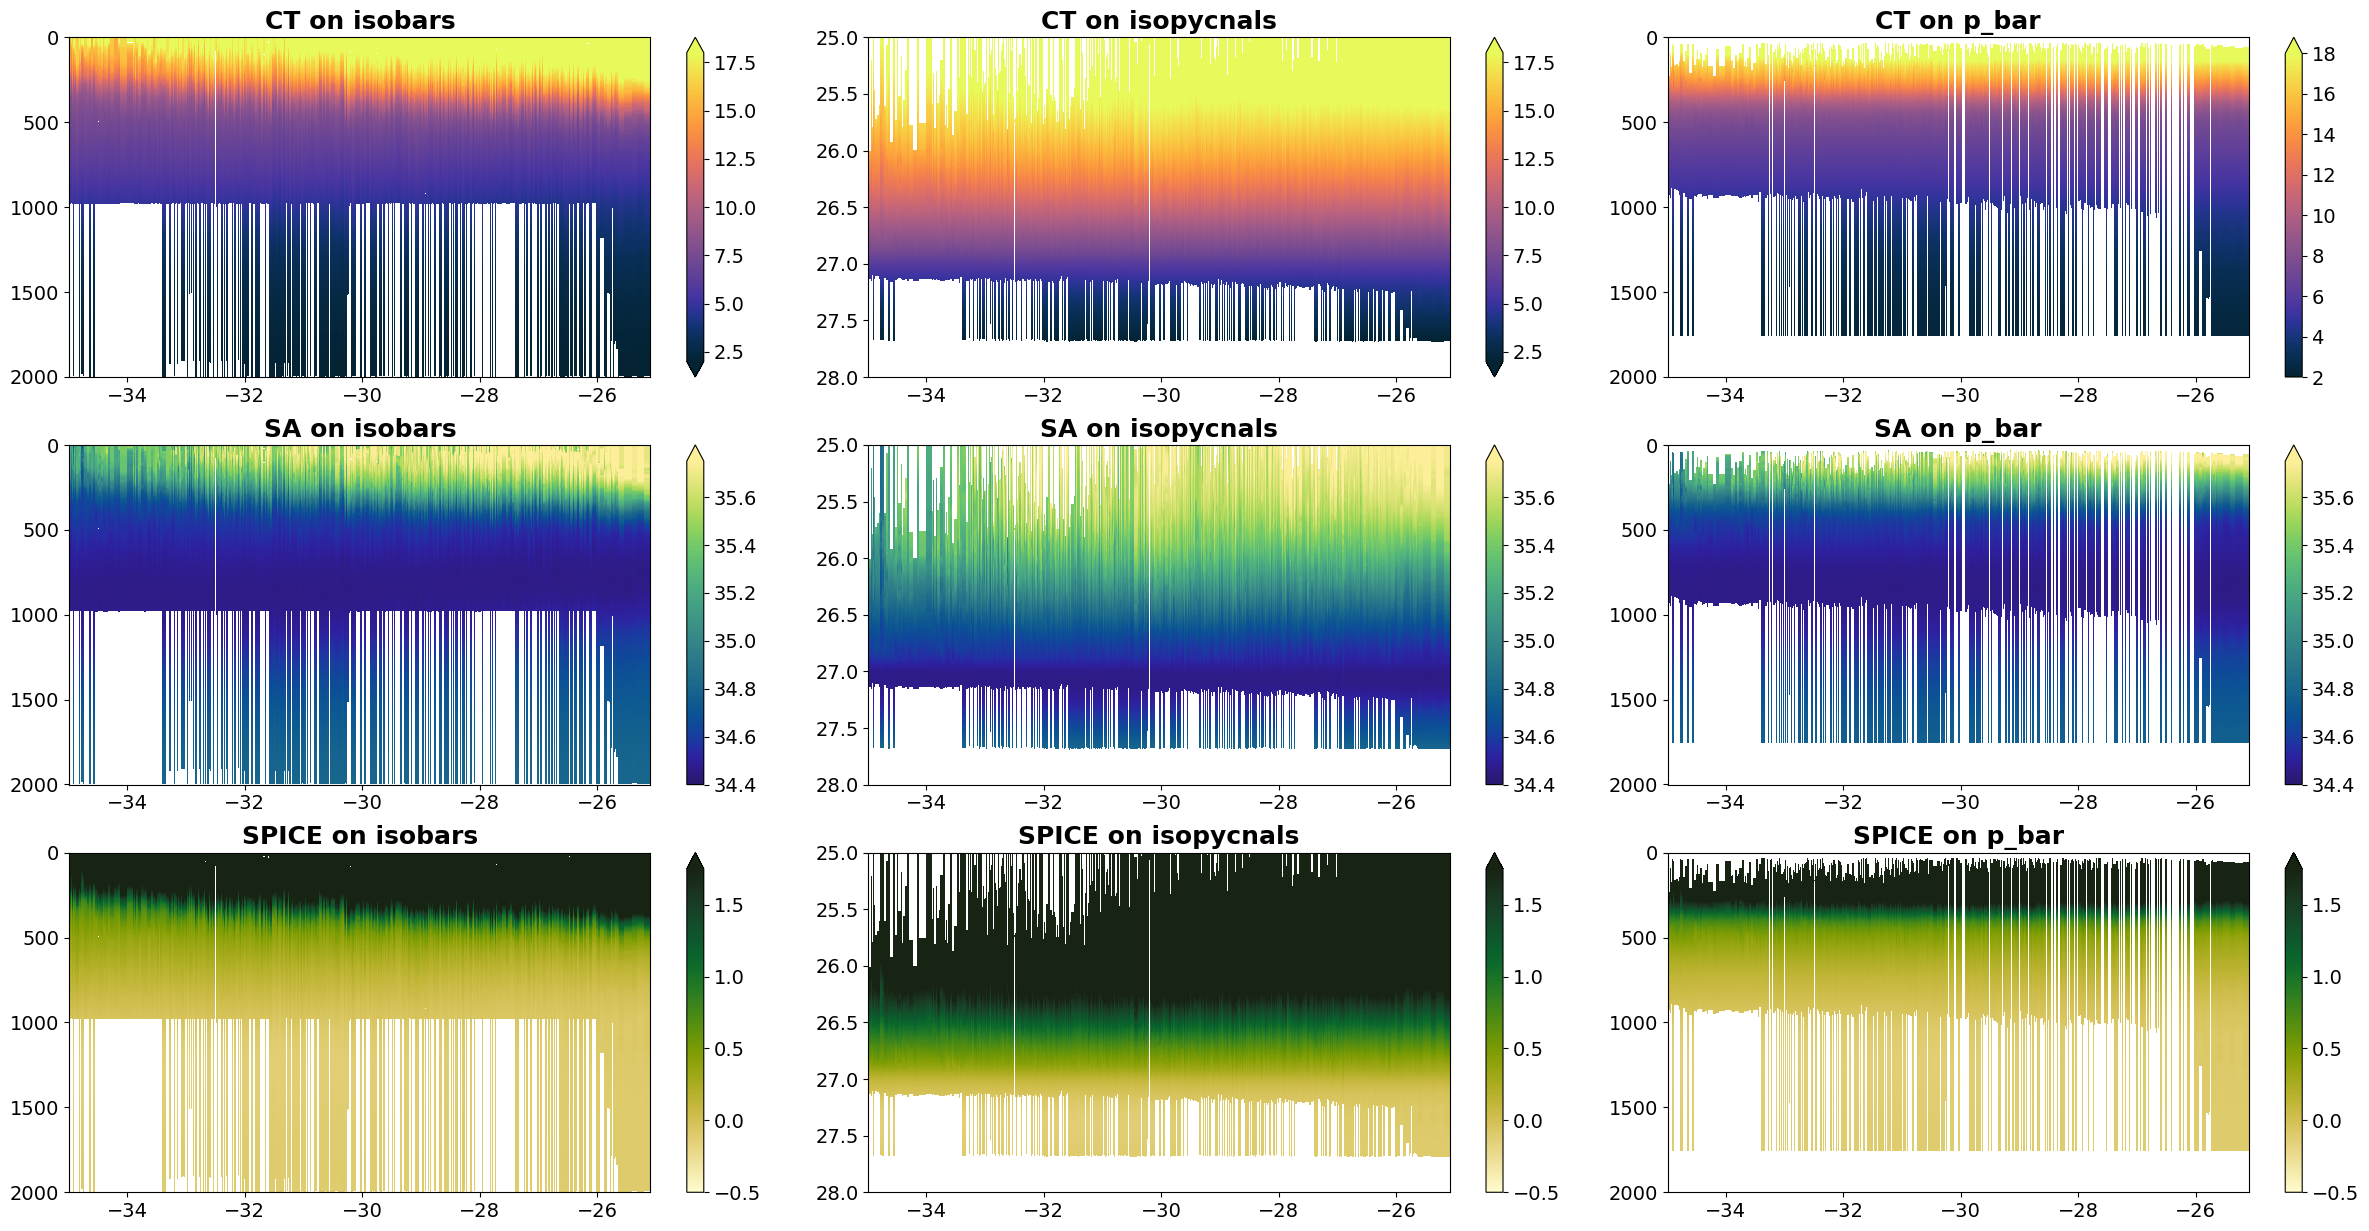

In [17]:
plt.figure(figsize=(30,15))
x = 'LATITUDE'
ct_cmap = cmo.thermal
ct_norm = colors.Normalize(vmin=2, vmax=18)
sa_cmap = cmo.haline
sa_norm = colors.Normalize(vmin=34.4, vmax=35.75)
sp_cmap = cmo.speed
sp_norm = colors.Normalize(vmin=-0.5, vmax=1.75)

plt.subplot(331)
section_p.CT.sortby(x).plot(x=x, y='depth', cmap=ct_cmap, norm=ct_norm, add_labels=False)
plt.gca().invert_yaxis()
plt.title('CT on isobars')

plt.subplot(332)
section_rho.CT.sortby(x).plot(x=x, y='density', cmap=ct_cmap, norm=ct_norm, add_labels=False)
plt.ylim(28,25)
plt.title('CT on isopycnals')

plt.subplot(333)
section_pmean.CT.sortby(x).plot(x=x, y='pmean', cmap=ct_cmap, norm=ct_norm, add_labels=False)
plt.gca().invert_yaxis()
plt.title('CT on p_bar')

plt.subplot(334)
section_p.SA.sortby(x).plot(x=x, y='depth', cmap=sa_cmap, norm=sa_norm, add_labels=False)
plt.gca().invert_yaxis()
plt.title('SA on isobars')

plt.subplot(335)
section_rho.SA.sortby(x).plot(x=x, y='density', cmap=sa_cmap, norm=sa_norm, add_labels=False)
plt.ylim(28,25)
plt.title('SA on isopycnals')

plt.subplot(336)
section_pmean.SA.sortby(x).plot(x=x, y='pmean', cmap=sa_cmap, norm=sa_norm, add_labels=False)
plt.gca().invert_yaxis()
plt.title('SA on p_bar')

plt.subplot(337)
section_p.SPICE.sortby(x).plot(x=x, y='depth', cmap=sp_cmap, norm=sp_norm, add_labels=False)
plt.gca().invert_yaxis()
plt.title('SPICE on isobars')

plt.subplot(338)
section_rho.SPICE.sortby(x).plot(x=x, y='density', cmap=sp_cmap, norm=sp_norm, add_labels=False)
plt.ylim(28,25)
plt.title('SPICE on isopycnals')

plt.subplot(339)
section_pmean.SPICE.sortby(x).plot(x=x, y='pmean', cmap=sp_cmap, norm=sp_norm, add_labels=False)
plt.gca().invert_yaxis()
plt.title('SPICE on p_bar')

plt.subplots_adjust(wspace=0.1, hspace=0.2)

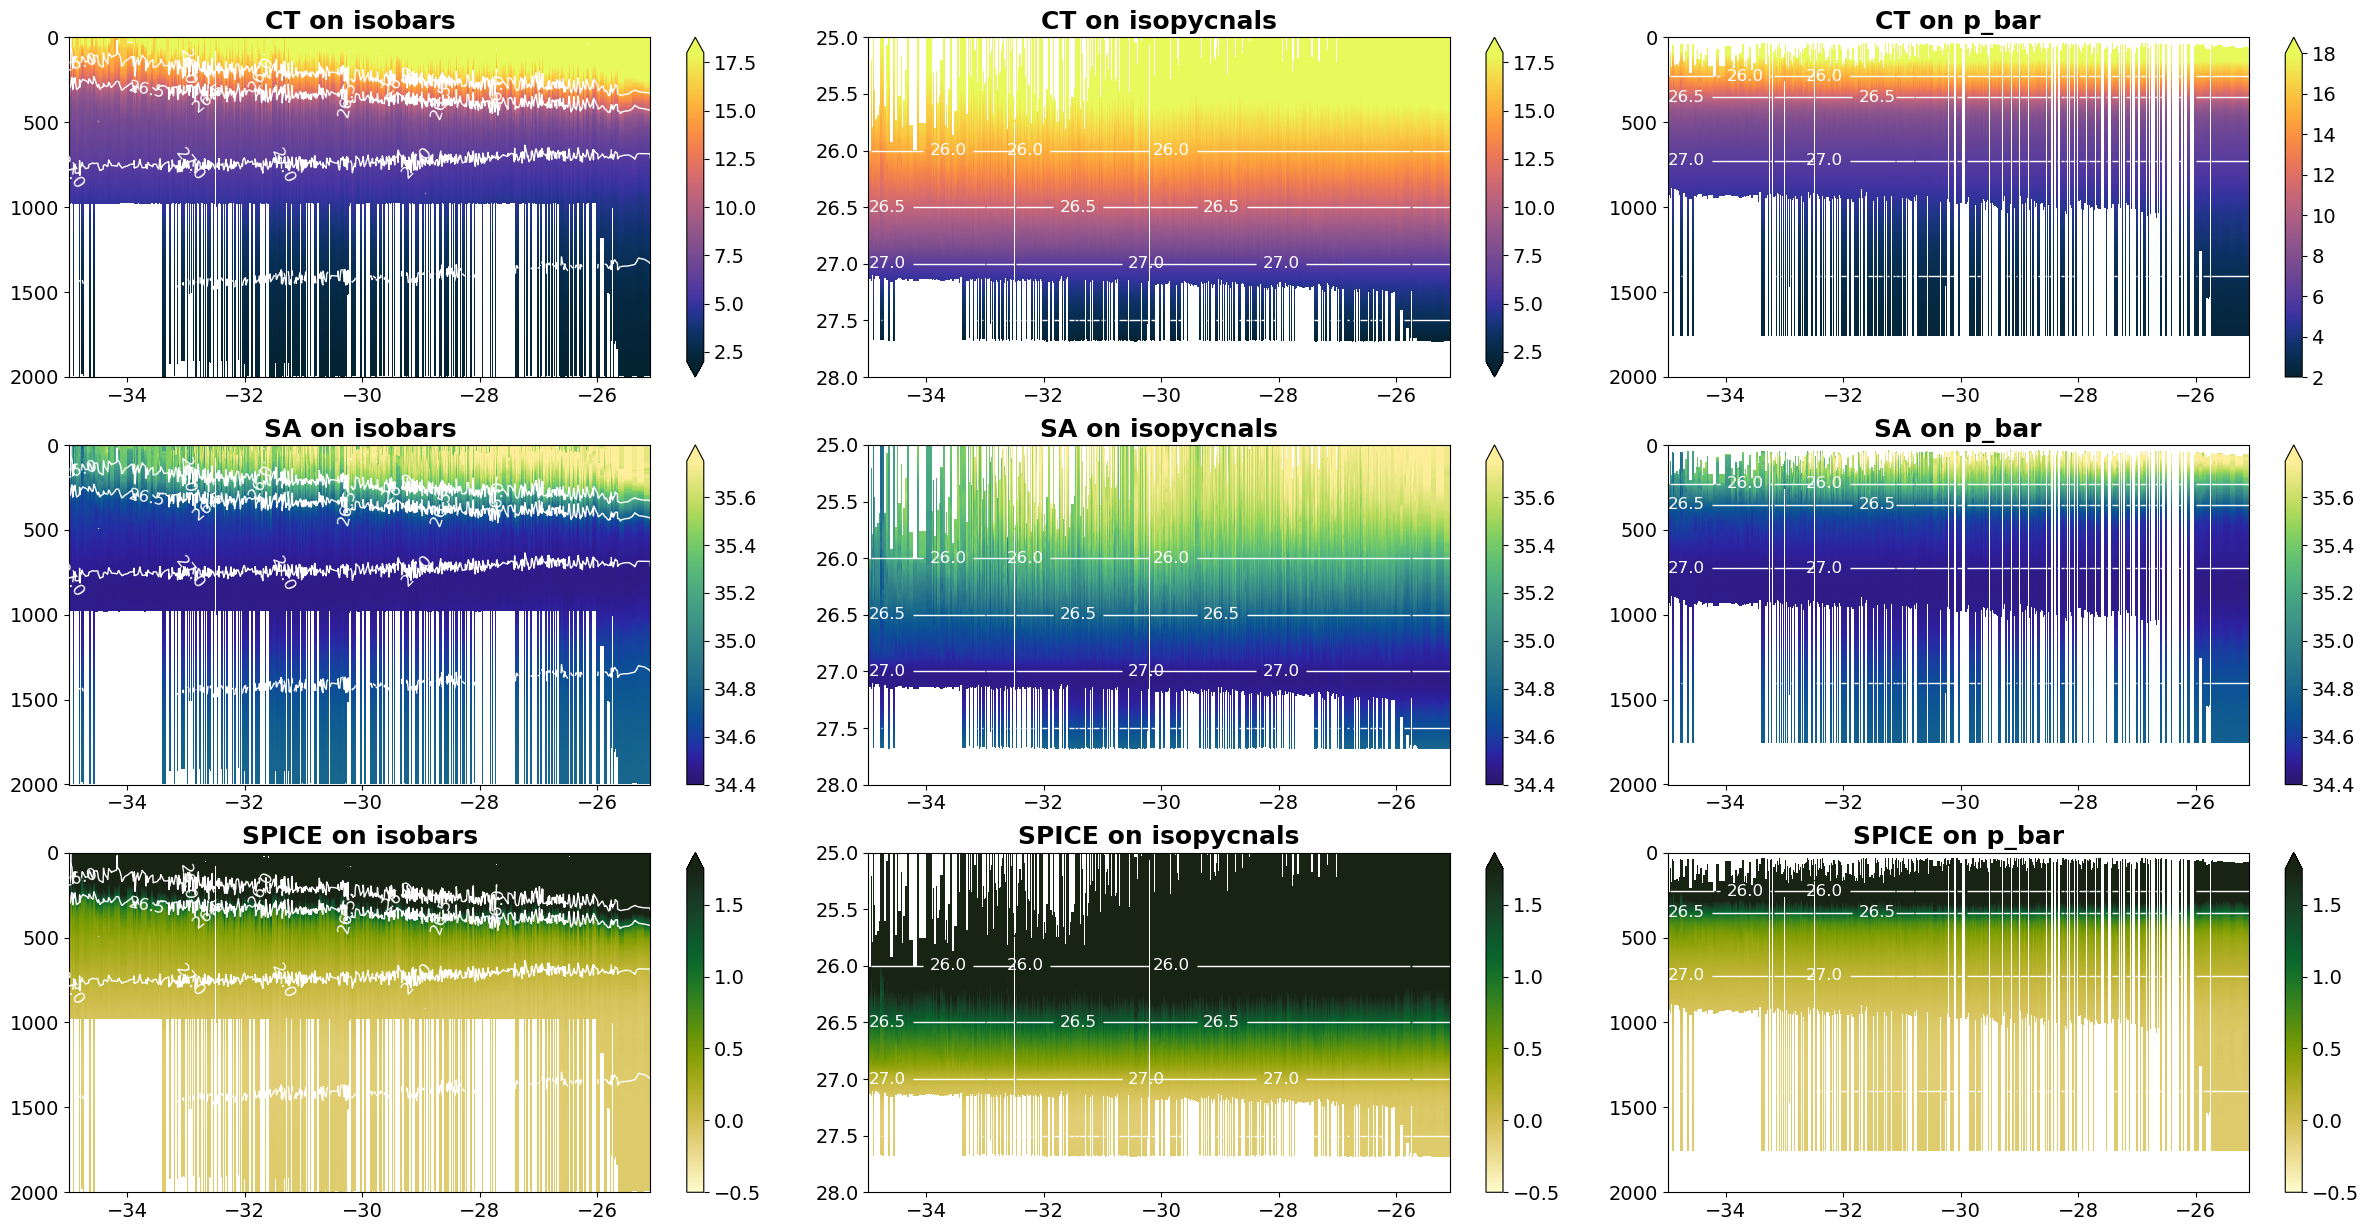

In [18]:
plt.figure(figsize=(30,15))

plt.subplot(331)
section_p.CT.sortby(x).plot(x=x, y='depth', cmap=ct_cmap, norm=ct_norm, add_labels=False)
contours1 = plt.contour(section_p.LATITUDE.values, section_p.depth.values, section_p.SIG0.values.T, levels=[26,26.5,27,27.5], colors='white', linewidths=1)
plt.clabel(contours1, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
plt.title('CT on isobars')

plt.subplot(332)
section_rho.CT.sortby(x).plot(x=x, y='density', cmap=ct_cmap, norm=ct_norm, add_labels=False)
contours2 = plt.contour(section_rho.LATITUDE.values, section_rho.density.values, section_rho.SIG0.values.T, levels=[26,26.5,27,27.5], colors='white', linewidths=1)
plt.clabel(contours2, inline=True, fontsize=12, fmt="%.1f")
plt.ylim(28,25)
plt.title('CT on isopycnals')

plt.subplot(333)
section_pmean.CT.sortby(x).plot(x=x, y='pmean', cmap=ct_cmap, norm=ct_norm, add_labels=False)
contours3 = plt.contour(section_pmean.LATITUDE.values, section_pmean.pmean.values, section_pmean.SIG0.values.T, levels=[26,26.5,27,27.5], colors='white', linewidths=1)
plt.clabel(contours3, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
plt.title('CT on p_bar')

plt.subplot(334)
section_p.SA.sortby(x).plot(x=x, y='depth', cmap=sa_cmap, norm=sa_norm, add_labels=False)
contours1 = plt.contour(section_p.LATITUDE.values, section_p.depth.values, section_p.SIG0.values.T, levels=[26,26.5,27,27.5], colors='white', linewidths=1)
plt.clabel(contours1, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
plt.title('SA on isobars')

plt.subplot(335)
section_rho.SA.sortby(x).plot(x=x, y='density', cmap=sa_cmap, norm=sa_norm, add_labels=False)
contours2 = plt.contour(section_rho.LATITUDE.values, section_rho.density.values, section_rho.SIG0.values.T, levels=[26,26.5,27,27.5], colors='white', linewidths=1)
plt.clabel(contours2, inline=True, fontsize=12, fmt="%.1f")
plt.ylim(28,25)
plt.title('SA on isopycnals')

plt.subplot(336)
section_pmean.SA.sortby(x).plot(x=x, y='pmean', cmap=sa_cmap, norm=sa_norm, add_labels=False)
contours3 = plt.contour(section_pmean.LATITUDE.values, section_pmean.pmean.values, section_pmean.SIG0.values.T, levels=[26,26.5,27,27.5], colors='white', linewidths=1)
plt.clabel(contours3, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
plt.title('SA on p_bar')

plt.subplot(337)
section_p.SPICE.sortby(x).plot(x=x, y='depth', cmap=sp_cmap, norm=sp_norm, add_labels=False)
contours1 = plt.contour(section_p.LATITUDE.values, section_p.depth.values, section_p.SIG0.values.T, levels=[26,26.5,27,27.5], colors='white', linewidths=1)
plt.clabel(contours1, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
plt.title('SPICE on isobars')

plt.subplot(338)
section_rho.SPICE.sortby(x).plot(x=x, y='density', cmap=sp_cmap, norm=sp_norm, add_labels=False)
contours2 = plt.contour(section_rho.LATITUDE.values, section_rho.density.values, section_rho.SIG0.values.T, levels=[26,26.5,27,27.5], colors='white', linewidths=1)
plt.clabel(contours2, inline=True, fontsize=12, fmt="%.1f")
plt.ylim(28,25)
plt.title('SPICE on isopycnals')

plt.subplot(339)
section_pmean.SPICE.sortby(x).plot(x=x, y='pmean', cmap=sp_cmap, norm=sp_norm, add_labels=False)
contours3 = plt.contour(section_pmean.LATITUDE.values, section_pmean.pmean.values, section_pmean.SIG0.values.T, levels=[26,26.5,27,27.5], colors='white', linewidths=1)
plt.clabel(contours3, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
plt.title('SPICE on p_bar')

plt.subplots_adjust(wspace=0.1, hspace=0.2)

## P_mean First: Variance Calculations

### Mesoscale Variance Production

In [19]:
K_rho_x = xr.open_dataset('/swot/SUM05/amf2288/global_diff.nc').K.drop_vars(['z_l','z_r','lon_l','lon_r','lat_l','lat_r'])

In [20]:
K_rho_sel_x = K_rho_x.sel(lon_c=section_p.LONGITUDE.mean(), lat_c=section_p.LATITUDE.mean(), method='nearest')
K_rho_sel_x = K_rho_sel_x.interp(z_c=section_p.depth).rename({'depth':'pmean'})

In [21]:
K_rho_sel_x

<xarray.DataArray 'K' (pmean: 1001)> Size: 8kB
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
    lat_c    float64 8B -30.0
    lon_c    float64 8B -139.5
    z_c      (pmean) int64 8kB 0 2 4 6 8 10 12 ... 1990 1992 1994 1996 1998 2000
  * pmean    (pmean) int64 8kB 0 2 4 6 8 10 12 ... 1990 1992 1994 1996 1998 2000

In [25]:
lfilt=100
rho_grid = np.arange(21,29,0.0025)
ct_m_pmean = ff.ds_filt_single(section_pmean.rename({'LATITUDE':'lat','LONGITUDE':'lon'}), lfilt, variable='CT', dim1='prof', dim2='pmean')
sa_m_pmean = ff.ds_filt_single(section_pmean.rename({'LATITUDE':'lat','LONGITUDE':'lon'}), lfilt, variable='SA', dim1='prof', dim2='pmean')
sp_m_pmean = ff.ds_filt_single(section_pmean.rename({'LATITUDE':'lat','LONGITUDE':'lon'}), lfilt, variable='SPICE', dim1='prof', dim2='pmean')

In [26]:
ct_e_pmean = section_pmean.CT - ct_m_pmean
sa_e_pmean = section_pmean.SA - sa_m_pmean
sp_e_pmean = section_pmean.SPICE - sp_m_pmean

In [27]:
ct_e_z2_pmean = ct_e_pmean.differentiate(coord='pmean')**2
sa_e_z2_pmean = sa_e_pmean.differentiate(coord='pmean')**2
sp_e_z2_pmean = sp_e_pmean.differentiate(coord='pmean')**2

In [28]:
ct_e_z2_filt_pmean = ff.da_filt_single(ct_e_z2_pmean, lfilt, dim1='prof', dim2='pmean')
sa_e_z2_filt_pmean = ff.da_filt_single(sa_e_z2_pmean, lfilt, dim1='prof', dim2='pmean')
sp_e_z2_filt_pmean = ff.da_filt_single(sp_e_z2_pmean, lfilt, dim1='prof', dim2='pmean')

In [29]:
ct_var2_pmean = ct_e_z2_filt_pmean
sa_var2_pmean = sa_e_z2_filt_pmean
sp_var2_pmean = sp_e_z2_filt_pmean

In [30]:
ct2_VPR_pmean = K_rho_sel_x*ct_var2_pmean
sa2_VPR_pmean = K_rho_sel_x*sa_var2_pmean
sp2_VPR_pmean = K_rho_sel_x*sp_var2_pmean

### Microscale Variance Production

In [31]:
ct_m_z3_pmean = ct_m_pmean.differentiate(coord='pmean')**2
sa_m_z3_pmean = sa_m_pmean.differentiate(coord='pmean')**2
sp_m_z3_pmean = sp_m_pmean.differentiate(coord='pmean')**2

In [32]:
ct_var3_pmean = ct_m_z3_pmean
sa_var3_pmean = sa_m_z3_pmean
sp_var3_pmean = sp_m_z3_pmean

In [33]:
ct3_VPR_pmean = K_rho_sel_x*ct_var3_pmean
sa3_VPR_pmean = K_rho_sel_x*sa_var3_pmean
sp3_VPR_pmean = K_rho_sel_x*sp_var3_pmean

## P_mean Last: Variance Calculations

In [34]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [35]:
def get_ds_rho(ds_z, da_SIG0, rho_grid, variables, dim1='N_PROF', dim2='PRES_INTERPOLATED'):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG0, ds_z[var],
            input_core_dims=[[dim2], [dim2]],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=[dim1, 'rho_grid'],
            coords={'rho_grid': rho_grid, dim1: ds_z[dim1]},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    #ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    ds_rho = ds_rho.assign_coords(LATITUDE  =(dim1, ds_z.LATITUDE.data))
    ds_rho = ds_rho.assign_coords(LONGITUDE =(dim1, ds_z.LONGITUDE.data))
    
    return ds_rho

### Mesoscale Variance Production

In [36]:
K_rho_rho = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/K_rho_3dx.nc').K_filt_3dx.rename({'lon':'lon_c','lat':'lat_c'})

In [37]:
K_rho_sel_rho = K_rho_rho.sel(lon_c=section_rho.LONGITUDE.mean(), lat_c=section_rho.LATITUDE.mean(), method='nearest')

In [38]:
K_rho_sel_rho

<xarray.DataArray 'K_filt_3dx' (density: 3200)> Size: 26kB
[3200 values with dtype=float64]
Coordinates:
    lon_c    float64 8B -139.5
    lat_c    float64 8B -30.0
  * density  (density) float64 26kB 21.0 21.0 21.01 21.01 ... 28.99 29.0 29.0

In [41]:
ct_m_p = ff.ds_filt_single(section_p.rename({'LATITUDE':'lat','LONGITUDE':'lon'}), lfilt, variable='CT', dim1='prof', dim2='depth')
sa_m_p = ff.ds_filt_single(section_p.rename({'LATITUDE':'lat','LONGITUDE':'lon'}), lfilt, variable='SA', dim1='prof', dim2='depth')
sp_m_p = ff.ds_filt_single(section_p.rename({'LATITUDE':'lat','LONGITUDE':'lon'}), lfilt, variable='SPICE', dim1='prof', dim2='depth')

In [42]:
ct_e_p = section_p.CT - ct_m_p
sa_e_p = section_p.SA - sa_m_p
sp_e_p = section_p.SPICE - sp_m_p

In [43]:
ct_e_z2_p = ct_e_p.differentiate(coord='depth')**2
sa_e_z2_p = sa_e_p.differentiate(coord='depth')**2
sp_e_z2_p = sp_e_p.differentiate(coord='depth')**2

In [44]:
ct_e_z2_filt_p = ff.da_filt_single(ct_e_z2_p, lfilt, dim1='prof', dim2='depth')
sa_e_z2_filt_p = ff.da_filt_single(sa_e_z2_p, lfilt, dim1='prof', dim2='depth')
sp_e_z2_filt_p = ff.da_filt_single(sp_e_z2_p, lfilt, dim1='prof', dim2='depth')

In [45]:
ct_e_z2_filt_p.name = 'ct_e_z2_filt_p'
ct_e_z2_filt_p = ct_e_z2_filt_p.to_dataset()

sa_e_z2_filt_p.name = 'sa_e_z2_filt_p'
sa_e_z2_filt_p = sa_e_z2_filt_p.to_dataset()

sp_e_z2_filt_p.name = 'sp_e_z2_filt_p'
sp_e_z2_filt_p = sp_e_z2_filt_p.to_dataset()

In [51]:
ct_var2_rho = get_ds_rho(ct_e_z2_filt_p, section_p.SIG0, rho_grid, ct_e_z2_filt_p, dim1='prof', dim2='depth').rename({'rho_grid':'density'})
sa_var2_rho = get_ds_rho(sa_e_z2_filt_p, section_p.SIG0, rho_grid, sa_e_z2_filt_p, dim1='prof', dim2='depth').rename({'rho_grid':'density'})
sp_var2_rho = get_ds_rho(sp_e_z2_filt_p, section_p.SIG0, rho_grid, sp_e_z2_filt_p, dim1='prof', dim2='depth').rename({'rho_grid':'density'})

Completed comp for ct_e_z2_filt_p


ValueError: coordinate N_PROF has dimensions ('depth',), but these are not a subset of the DataArray dimensions ('N_PROF', 'rho_grid')

In [ ]:
ct2_VPR_rho = K_rho_sel_rho*ct_var2_rho
sa2_VPR_rho = K_rho_sel_rho*sa_var2_rho
sp2_VPR_rho = K_rho_sel_rho*sp_var2_rho

In [ ]:
ct2_VPR_rho['PRES'] = (('prof','density'), section_rho.PRES.data)
sa2_VPR_rho['PRES'] = (('prof','density'), section_rho.PRES.data)
sp2_VPR_rho['PRES'] = (('prof','density'), section_rho.PRES.data)

In [ ]:
ct2_VPR_rho_pmean = get_ds_pmean(ct2_VPR_rho, np.arange(0,2001,2), ct_e_z2_filt_p, dim1='prof', dim2='density').ct_e_z2_filt_p.rename({'pmean_grid':'pmean'})
sa2_VPR_rho_pmean = get_ds_pmean(sa2_VPR_rho, np.arange(0,2001,2), sa_e_z2_filt_p, dim1='prof', dim2='density').sa_e_z2_filt_p.rename({'pmean_grid':'pmean'})
sp2_VPR_rho_pmean = get_ds_pmean(sp2_VPR_rho, np.arange(0,2001,2), sp_e_z2_filt_p, dim1='prof', dim2='density').sp_e_z2_filt_p.rename({'pmean_grid':'pmean'})

### Microscale Variance Production

In [ ]:
ct_m_z3_p = ct_m_p.differentiate(coord='depth')**2
sa_m_z3_p = sa_m_p.differentiate(coord='depth')**2
sp_m_z3_p = sp_m_p.differentiate(coord='depth')**2

In [ ]:
ct_m_z3_p.name = 'ct_m_z3_p'
ct_m_z3_p = ct_m_z3_p.to_dataset()

sa_m_z3_p.name = 'sa_m_z3_p'
sa_m_z3_p = sa_m_z3_p.to_dataset()

sp_m_z3_p.name = 'sp_m_z3_p'
sp_m_z3_p = sp_m_z3_p.to_dataset()

In [ ]:
ct_var3_rho = get_ds_rho(ct_m_z3_p, section_p.SIG0, rho_grid, ct_m_z3_p, dim1='prof', dim2='depth').rename({'rho_grid':'density'})
sa_var3_rho = get_ds_rho(sa_m_z3_p, section_p.SIG0, rho_grid, sa_m_z3_p, dim1='prof', dim2='depth').rename({'rho_grid':'density'})
sp_var3_rho = get_ds_rho(sp_m_z3_p, section_p.SIG0, rho_grid, sp_m_z3_p, dim1='prof', dim2='depth').rename({'rho_grid':'density'})

In [ ]:
ct3_VPR_rho = K_rho_sel_rho*ct_var3_rho
sa3_VPR_rho = K_rho_sel_rho*sa_var3_rho
sp3_VPR_rho = K_rho_sel_rho*sp_var3_rho

In [ ]:
ct3_VPR_rho['PRES'] = (('prof','density'), section_rho.PRES.data)
sa3_VPR_rho['PRES'] = (('prof','density'), section_rho.PRES.data)
sp3_VPR_rho['PRES'] = (('prof','density'), section_rho.PRES.data)

In [ ]:
ct3_VPR_rho_pmean = get_ds_pmean(ct3_VPR_rho, np.arange(0,2001,2), ct_m_z3_p, dim1='prof', dim2='density').ct_m_z3_p.rename({'pmean_grid':'pmean'})
sa3_VPR_rho_pmean = get_ds_pmean(sa3_VPR_rho, np.arange(0,2001,2), sa_m_z3_p, dim1='prof', dim2='density').sa_m_z3_p.rename({'pmean_grid':'pmean'})
sp3_VPR_rho_pmean = get_ds_pmean(sp3_VPR_rho, np.arange(0,2001,2), sp_m_z3_p, dim1='prof', dim2='density').sp_m_z3_p.rename({'pmean_grid':'pmean'})

## Plots! :)

In [54]:
x = 'lat'

NameError: name 'ct2_VPR_rho_pmean' is not defined

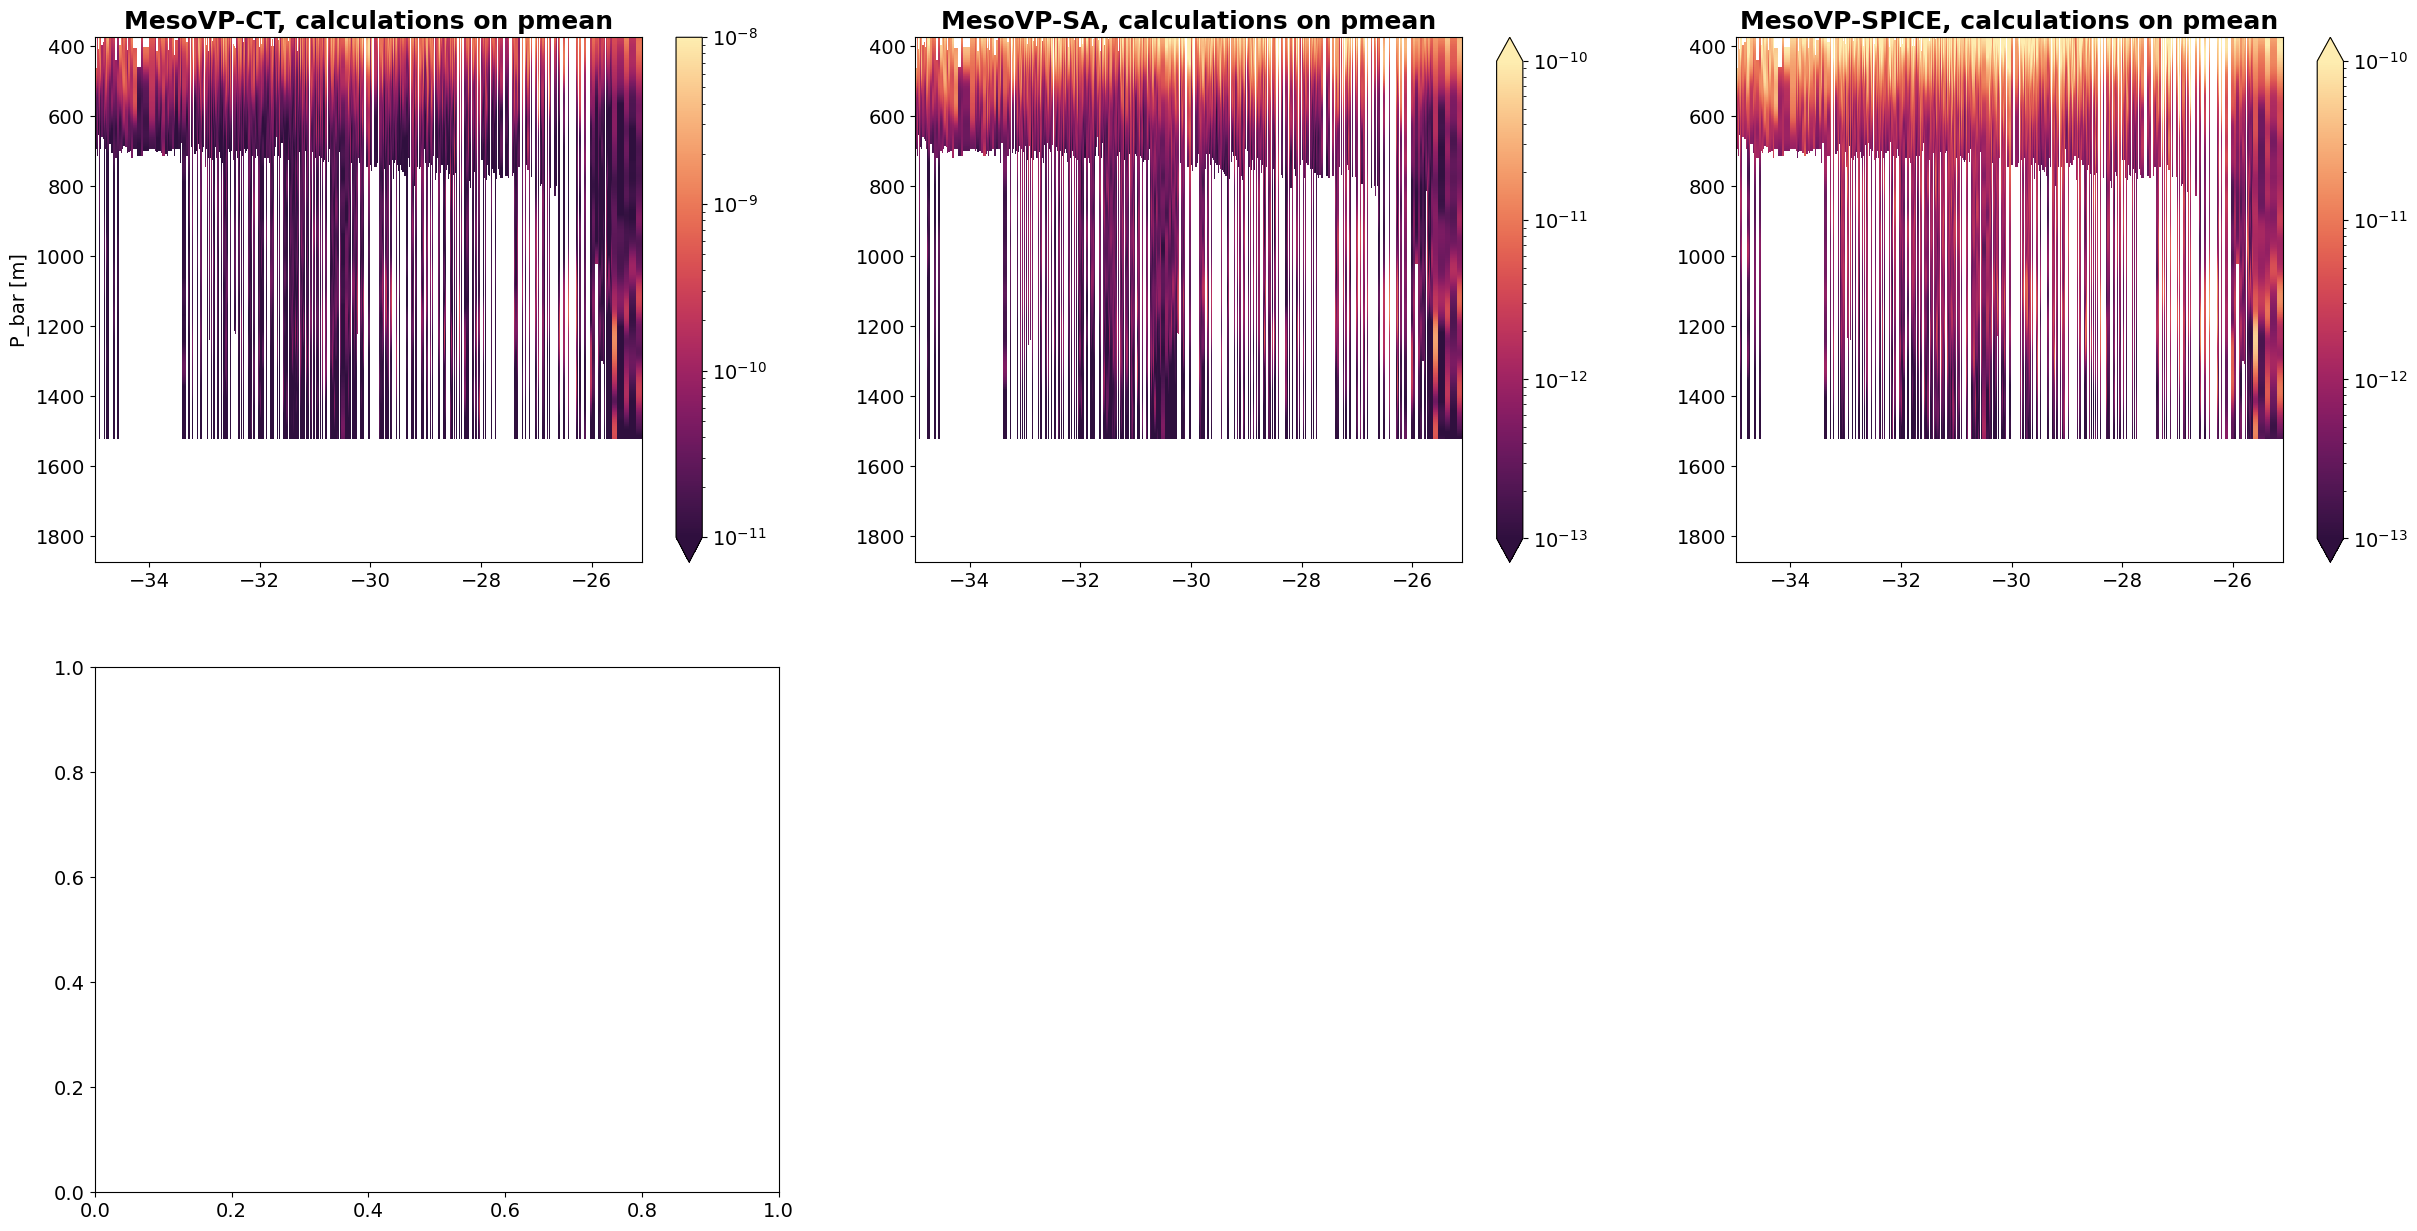

In [55]:
plt.figure(figsize=(30,15))

cmap    = cmo.matter_r
ct_norm = colors.LogNorm(vmin=1e-11,vmax=1e-8)
sa_norm = colors.LogNorm(vmin=1e-13,vmax=1e-10)
sp_norm = colors.LogNorm(vmin=1e-13,vmax=1e-10)

plt.subplot(231)
ct2_VPR_pmean.sortby(x).plot(x=x, y='pmean', cmap=cmap, norm=ct_norm, add_labels=False)
plt.ylim(375,1875)
plt.ylabel('P_bar [m]')
plt.gca().invert_yaxis()
plt.title('MesoVP-CT, calculations on pmean')

plt.subplot(232)
sa2_VPR_pmean.sortby(x).plot(x=x, y='pmean', cmap=cmap, norm=sa_norm, add_labels=False)
plt.ylim(375,1875)
plt.gca().invert_yaxis()
plt.title('MesoVP-SA, calculations on pmean')

plt.subplot(233)
sp2_VPR_pmean.sortby(x).plot(x=x, y='pmean', cmap=cmap, norm=sp_norm, add_labels=False)
plt.ylim(375,1875)
plt.gca().invert_yaxis()
plt.title('MesoVP-SPICE, calculations on pmean')

plt.subplot(234)
ct2_VPR_rho_pmean.sortby(x).plot(x=x, y='pmean', cmap=cmap, norm=ct_norm, add_labels=False)
plt.ylim(375,1875)
plt.ylabel('P_bar [m]')
plt.gca().invert_yaxis()
plt.title('MesoVP-CT, calculations on p')

plt.subplot(235)
sa2_VPR_rho_pmean.sortby(x).plot(x=x, y='pmean', cmap=cmap, norm=sa_norm, add_labels=False)
plt.ylim(375,1875)
plt.gca().invert_yaxis()
plt.title('MesoVP-SA, calculations on p')

plt.subplot(236)
sp2_VPR_rho_pmean.sortby(x).plot(x=x, y='pmean', cmap=cmap, norm=sp_norm, add_labels=False)
plt.ylim(375,1875)
plt.gca().invert_yaxis()
plt.title('MesoVP-SPICE, calculations on p')

plt.subplots_adjust(wspace=0.2, hspace=0.25)

In [ ]:
plt.figure(figsize=(30,15))

cmap    = cmo.matter_r
ct_norm = colors.LogNorm(vmin=1e-11,vmax=1e-8)
sa_norm = colors.LogNorm(vmin=1e-13,vmax=1e-10)
sp_norm = colors.LogNorm(vmin=1e-13,vmax=1e-10)

plt.subplot(231)
ct3_VPR_pmean.sortby(x).plot(x=x, y='pmean', cmap=cmap, norm=ct_norm, add_labels=False)
plt.ylim(375,1875)
plt.ylabel('P_bar [m]')
plt.gca().invert_yaxis()
plt.title('MicroVP-CT, calculations on pmean')

plt.subplot(232)
sa3_VPR_pmean.sortby(x).plot(x=x, y='pmean', cmap=cmap, norm=sa_norm, add_labels=False)
plt.ylim(375,1875)
plt.gca().invert_yaxis()
plt.title('MicroVP-SA, calculations on pmean')

plt.subplot(233)
sp3_VPR_pmean.sortby(x).plot(x=x, y='pmean', cmap=cmap, norm=sp_norm, add_labels=False)
plt.ylim(375,1875)
plt.gca().invert_yaxis()
plt.title('MicroVP-SPICE, calculations on pmean')

plt.subplot(234)
ct3_VPR_rho_pmean.sortby(x).plot(x=x, y='pmean', cmap=cmap, norm=ct_norm, add_labels=False)
plt.ylim(375,1875)
plt.ylabel('P_bar [m]')
plt.gca().invert_yaxis()
plt.title('MicroVP-CT, calculations on p')

plt.subplot(235)
sa3_VPR_rho_pmean.sortby(x).plot(x=x, y='pmean', cmap=cmap, norm=sa_norm, add_labels=False)
plt.ylim(375,1875)
plt.gca().invert_yaxis()
plt.title('MicroVP-SA, calculations on p')

plt.subplot(236)
sp3_VPR_rho_pmean.sortby(x).plot(x=x, y='pmean', cmap=cmap, norm=sp_norm, add_labels=False)
plt.ylim(375,1875)
plt.gca().invert_yaxis()
plt.title('MicroVP-SPICE, calculations on p')

plt.subplots_adjust(wspace=0.2, hspace=0.25)

In [ ]:
ct_meso_frac_pmean = ct2_VPR_pmean.mean('prof') / (ct2_VPR_pmean.mean('prof')+ct3_VPR_pmean.mean('prof'))
ct_meso_frac_rho_pmean = ct2_VPR_rho_pmean.mean('prof') / (ct2_VPR_rho_pmean.mean('prof')+ct3_VPR_rho_pmean.mean('prof'))

sa_meso_frac_pmean = sa2_VPR_pmean.mean('prof') / (sa2_VPR_pmean.mean('prof')+sa3_VPR_pmean.mean('prof'))
sa_meso_frac_rho_pmean = sa2_VPR_rho_pmean.mean('prof') / (sa2_VPR_rho_pmean.mean('prof')+sa3_VPR_rho_pmean.mean('prof'))

In [ ]:
ct_meso_frac_pmean.plot(y='pmean',label='calc on pmean, CT',color='tab:blue')
sa_meso_frac_pmean.plot(y='pmean',label='calc on pmean, SA',color='tab:orange')
ct_meso_frac_rho_pmean.plot(y='pmean',label='calc on p, CT',color='tab:blue', linestyle='--')
sa_meso_frac_rho_pmean.plot(y='pmean',label='calc on p, SA',color='tab:orange', linestyle='--')
plt.legend()
plt.gca().invert_yaxis()

In [ ]:
sa2_VPR_pmean.mean('prof').plot(y='pmean',label='meso')
sa3_VPR_pmean.mean('prof').plot(y='pmean',label='micro')
sa2_VPR_rho_pmean.mean('prof').plot(y='pmean',label='meso',linestyle='--',color='tab:blue')
sa3_VPR_rho_pmean.mean('prof').plot(y='pmean',label='micro',linestyle='--',color='tab:orange')
plt.xscale('log')
plt.legend()
plt.gca().invert_yaxis()

## Individual Profiles

In [ ]:
section_p

In [ ]:
plt.figure(figsize=(10,12))
prof=300

plt.subplot(231)
section_p.CT.isel(prof=prof).plot(y='depth', label='T[p]', linewidth=2)
section_pmean.CT.isel(prof=prof).plot(y='pmean', label='T[rho]', linewidth=2)
ct_m_p.isel(prof=prof).plot(y='depth', linestyle='--', linewidth=1, color='k')
ct_m_pmean.isel(prof=prof).plot(y='pmean', label='T_m', linestyle='--', linewidth=1, color='k')
plt.gca().invert_yaxis()
plt.legend()
plt.title(f'CT, profile: {prof}')

plt.subplot(232)
section_p.SA.isel(prof=prof).plot(y='depth', label='T[p]')
section_pmean.SA.isel(prof=prof).plot(y='pmean', label='T[rho]')
sa_m_p.isel(prof=prof).plot(y='depth', linestyle='--', linewidth=1, color='k')
sa_m_pmean.isel(prof=prof).plot(y='pmean', label='T_m', linestyle='--', linewidth=1, color='k')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.title('SA')

plt.subplot(233)
section_p.SPICE.isel(prof=prof).plot(y='depth', label='T[p]')
section_pmean.SPICE.isel(prof=prof).plot(y='pmean', label='T[rho]')
sp_m_p.isel(prof=prof).plot(y='depth', linestyle='--', linewidth=1, color='k')
sp_m_pmean.isel(prof=prof).plot(y='pmean', label='T_m', linestyle='--', linewidth=1, color='k')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.title('SPICE')

plt.subplot(234)
ct_e_p.isel(prof=prof).plot(y='depth', label='calculated on p')
ct_e_pmean.isel(prof=prof).plot(y='pmean', label='calculated on p')
plt.gca().invert_yaxis()
plt.legend()
plt.title('CT_e')

plt.subplot(235)
sa_e_p.isel(prof=prof).plot(y='depth', label='calculated on p')
sa_e_pmean.isel(prof=prof).plot(y='pmean', label='calculated on pmean')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.title('SA_e')

plt.subplot(236)
sp_e_p.isel(prof=prof).plot(y='depth', label='calculated on p')
sp_e_pmean.isel(prof=prof).plot(y='pmean', label='calculated on p')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.title('SPICE_e')

plt.subplots_adjust(wspace=0.3)